# exp6. 프로젝트 : 네이버 영화리뷰 감성분석

네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus  
https://github.com/e9t/nsmc

### 0. 루브릭
***

|**평가문항**|**상세기준**|
|------------|-------------|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

### 1. 데이터 준비와 확인
***

In [1]:
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages') # MeCab 오류로 인해 패스 경로 추가
sys.path.append('C:\\Users\\Helpe\\anaconda3\\lib\\site-packages')

# 데이터를 읽어봅시다. 
train_data = pd.read_table('D:/project/sentiment_classification/data/nsmc-master/ratings_train.txt')
test_data = pd.read_table('D:/project/sentiment_classification/data/nsmc-master/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.document[0])
print(train_data.label[0])

train_data.info()
train_data.describe()

아 더빙.. 진짜 짜증나네요 목소리
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,label
count,1.500000e+05,150000.000000
mean,6.743533e+06,0.498847
std,2.919051e+06,0.500000
min,3.300000e+01,0.000000
25%,4.766881e+06,0.000000
50%,7.526840e+06,0.000000
75%,9.249435e+06,1.000000
max,1.027815e+07,1.000000


In [3]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


### 2. 데이터로더 구성
***
nsmc 데이터셋은 IMDB에서 제공했던 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리가 없다.  
가공되지 않은 텍스트 파일들을 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작함

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
# 중복 데이터 확인 
# nunique() : 중복되지 않은 데이터의 갯수 
print(train_data['document'].nunique())  #146182


146182


In [5]:
# 결측치 확인 
print(train_data.isnull().values.any()) # True 
print(test_data.isnull().values.any()) # True 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

True
True
id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [6]:
from eunjeon import Mecab # MeCab 오류로 eunjeon 사용
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
print(word_to_index['정말'])  # 정말은 인덱스 29

29


In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공
***

#### 3.1 데이터셋 내 문장 길이 분포

In [10]:
# 전체 데이터 셋 통합 
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.972842084785936
문장길이 최대 :  116
문장길이 표준편차 :  12.843357707480491


#### 3.2 적절한 최대 문장 길이 지정

In [11]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


#### 3.3 패딩 추가
`keras.preprocessing.sequence.pad_sequences` 을 활용

In [12]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, 
                                                     value=word_to_index['<PAD>'],
                                                     padding='pre', # 혹은 'pre'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test, 
                                                    value=word_to_index['<PAD>'],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)

print(X_train.shape)

(146182, 41)


#### 3.4 validation set 구성

In [13]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.3, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(102327, 41) (102327,)
(43855, 41) (43855,)


### 4. 모델 구성 / 훈련 / Loss, Accuracy 그래프 시각화
***

#### 4.1 모델1 Convolution Neural Network(1-D CNN) 모델

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1

In [15]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = cnn_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/8
200/200 - 3s - loss: 0.5233 - accuracy: 0.7436 - val_loss: 0.3733 - val_accuracy: 0.8349 - 3s/epoch - 17ms/step
Epoch 2/8
200/200 - 1s - loss: 0.3356 - accuracy: 0.8574 - val_loss: 0.3515 - val_accuracy: 0.8468 - 1s/epoch - 6ms/step
Epoch 3/8
200/200 - 1s - loss: 0.3005 - accuracy: 0.8762 - val_loss: 0.3492 - val_accuracy: 0.8484 - 1s/epoch - 6ms/step
Epoch 4/8
200/200 - 1s - loss: 0.2763 - accuracy: 0.8872 - val_loss: 0.3511 - val_accuracy: 0.8486 - 1s/epoch - 6ms/step
Epoch 5/8
200/200 - 1s - loss: 0.2503 - accuracy: 0.9010 - val_loss: 0.3584 - val_accuracy: 0.8476 - 1s/epoch - 7ms/step
Epoch 6/8
200/200 - 1s - loss: 0.2227 - accuracy: 0.9154 - val_loss: 0.3762 - val_accuracy: 0.8448 - 1s/epoch - 6ms/step
Epoch 7/8
200/200 - 1s - loss: 0.1933 - accuracy: 0.9297 - val_loss: 0.3974 - val_accuracy: 0.8412 - 1s/epoch - 7ms/step
Epoch 8/8
200/200 - 1s - loss: 0.1652 - accuracy: 0.9420 - val_loss: 0.4295 - val_accuracy: 0.8384 - 1s/epoch - 7ms/step


In [16]:
results = cnn_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4344 - accuracy: 0.8368 - 4s/epoch - 2ms/step
[0.43435990810394287, 0.8368289470672607]


In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


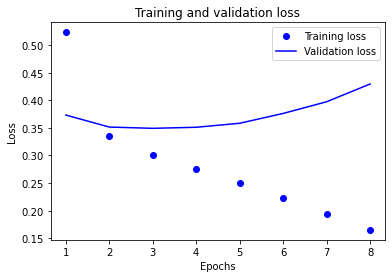

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

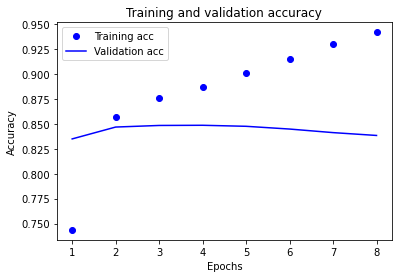

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4.2 모델2 LSTM 모델

In [20]:
#LSTM

#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)
word_vector_dim = 16  

#LSTM 레이어로 모델 설계
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [21]:
#LSTM 레이어 모델 학습

lstm_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=8
batch_size=512

history = lstm_model.fit(x_train,
                    y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/8
200/200 [==============================] - 3s 10ms/step - loss: 0.5304 - accuracy: 0.7452 - val_loss: 0.3824 - val_accuracy: 0.8359
Epoch 2/8
200/200 [==============================] - 2s 8ms/step - loss: 0.3459 - accuracy: 0.8549 - val_loss: 0.3558 - val_accuracy: 0.8464
Epoch 3/8
200/200 [==============================] - 2s 9ms/step - loss: 0.3143 - accuracy: 0.8707 - val_loss: 0.3536 - val_accuracy: 0.8475
Epoch 4/8
200/200 [==============================] - 2s 9ms/step - loss: 0.2985 - accuracy: 0.8778 - val_loss: 0.3562 - val_accuracy: 0.8467
Epoch 5/8
200/200 [==============================] - 2s 8ms/step - loss: 0.2859 - accuracy: 0.8837 - val_loss: 0.3576 - val_accuracy: 0.8471
Epoch 6/8
200/200 [==============================] - 2s 8ms/step - loss: 0.2758 - accuracy: 0.8898 - val_loss: 0.3646 - val_accuracy: 0.8458
Epoch 7/8
200/200 [==============================] - 2s 9ms/step - loss: 0.2647 - accuracy: 0.8948 - val_loss: 0.3688 - val_accuracy: 0.8450
Epoch 8/8
20

In [22]:
results = lstm_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3730 - accuracy: 0.8446 - 4s/epoch - 3ms/step
[0.3729858100414276, 0.8445592522621155]


In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


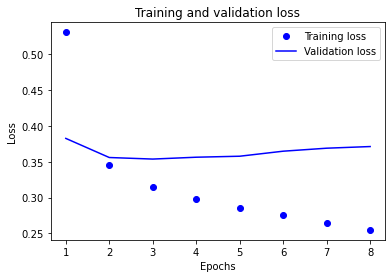

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

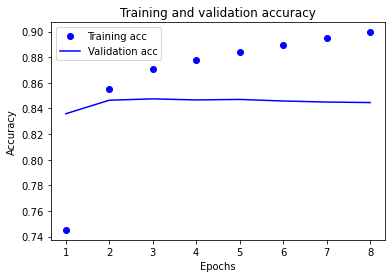

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4.3 모델3 GlobalMaxPooling 1D 


In [26]:
vocab_size = 10000    

word_vector_dim = 16  

glo_model = keras.Sequential()
glo_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
glo_model.add(keras.layers.GlobalMaxPooling1D())
glo_model.add(keras.layers.Dense(8, activation='relu'))
glo_model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

glo_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [27]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
glo_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=8
batch_size=512

history = glo_model.fit(x_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/8
200/200 [==============================] - 2s 6ms/step - loss: 0.6220 - accuracy: 0.7227 - val_loss: 0.5008 - val_accuracy: 0.8052
Epoch 2/8
200/200 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8330 - val_loss: 0.3878 - val_accuracy: 0.8320
Epoch 3/8
200/200 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.8587 - val_loss: 0.3649 - val_accuracy: 0.8403
Epoch 4/8
200/200 [==============================] - 1s 6ms/step - loss: 0.3065 - accuracy: 0.8742 - val_loss: 0.3594 - val_accuracy: 0.8433
Epoch 5/8
200/200 [==============================] - 1s 6ms/step - loss: 0.2830 - accuracy: 0.8855 - val_loss: 0.3606 - val_accuracy: 0.8446
Epoch 6/8
200/200 [==============================] - 1s 6ms/step - loss: 0.2642 - accuracy: 0.8947 - val_loss: 0.3656 - val_accuracy: 0.8445
Epoch 7/8
200/200 [==============================] - 1s 6ms/step - loss: 0.2486 - accuracy: 0.9016 - val_loss: 0.3740 - val_accuracy: 0.8439
Epoch 8/8
200

In [29]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


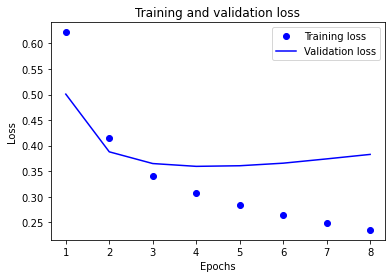

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

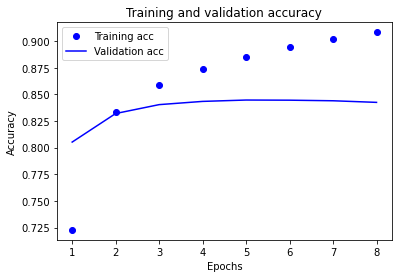

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4.4 모델 평가

* epoch는 모델별로 3~4회가 가장 적당해 보인다.
* cnn 정확도 0.836
* lstm 정확도 0.844
* globalMaxPooling 정확도 0.840

### 7. 학습된 Embedding 레이어 분석

In [33]:
# 정확도가 가장 높았던 lstm 모델로 진행
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
word2vec_file_path = 'D:/project/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w', encoding='utf-8') # 인코딩 에러가 발생하여 encoding='utf-8' 옵션 추가
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['진짜']
vector

array([ 0.06319272,  0.06249583, -0.0112858 , -0.04754043, -0.03524493,
        0.05744258,  0.01952283,  0.00067592, -0.02793249,  0.01916697,
       -0.03516394,  0.02719458, -0.10597236,  0.09819852, -0.10834508,
       -0.13497049], dtype=float32)

In [37]:
word_vectors.similar_by_word("강아지")

[('심금', 0.9215506315231323),
 ('동굴', 0.905389666557312),
 ('맑', 0.8980464935302734),
 ('월요일', 0.897432267665863),
 ('나누', 0.8919614553451538),
 ('큐', 0.8890422582626343),
 ('강인', 0.888512134552002),
 ('고조', 0.879338800907135),
 ('펭귄', 0.8785979747772217),
 ('파이널', 0.8775042295455933)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

Pre-trained word vectors of 30+ languages  
https://github.com/Kyubyong/wordvectors  

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

#### 8.1 Pre-trained word vectors 적용 및 유사도 확인

In [51]:
'''
와..gensim 오류때문에 제법 고생했다....
'''

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = 'D:/project/sentiment_classification/data/ko.bin'
pre_model = Word2Vec.load(word2vec_path)
pre_model.wv.most_similar("강아지")

[('고양이', 0.7290453314781189),
 ('거위', 0.7185634970664978),
 ('토끼', 0.7056223750114441),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.693433403968811),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.675035297870636),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512461304664612)]

In [52]:
pre_model.wv.most_similar("경찰")

[('경찰관', 0.7636125087738037),
 ('헌병', 0.7307591438293457),
 ('경찰의', 0.7197772264480591),
 ('헌병대', 0.6756091117858887),
 ('기동대', 0.6579593420028687),
 ('경시청', 0.6463156938552856),
 ('경찰청', 0.637272834777832),
 ('군부대', 0.6155546307563782),
 ('경찰서', 0.6103807091712952),
 ('보안과', 0.60479736328125)]

확실히 한국어 Word2Vec을 적용한게 단어의 유사도가 높았다.

#### 8.2 개선된 임베드 적용

In [53]:
from tensorflow.keras.initializers import Constant

word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

C:\Users\Helpe\AppData\Local\Temp/ipykernel_20136/564142931.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
C:\Users\Helpe\AppData\Local\Temp/ipykernel_20136/564142931.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
pre_model = keras.Sequential()
pre_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
pre_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
pre_model.add(keras.layers.MaxPooling1D(5))
pre_model.add(keras.layers.Conv1D(32, 7, activation='relu'))
pre_model.add(keras.layers.GlobalMaxPooling1D())
pre_model.add(keras.layers.Dense(32, activation='relu'))
pre_model.add(keras.layers.Dense(1, activation='sigmoid')) 

pre_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d_8 (Conv1D)           (None, 35, 16)            22416     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 32)             3616      
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 32)               

In [55]:
pre_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8
batch_size=512

history = pre_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
200/200 [==============================] - 3s 15ms/step - loss: 0.5332 - accuracy: 0.7224 - val_loss: 0.4427 - val_accuracy: 0.7939
Epoch 2/8
200/200 [==============================] - 5s 23ms/step - loss: 0.3891 - accuracy: 0.8260 - val_loss: 0.3864 - val_accuracy: 0.8285
Epoch 3/8
200/200 [==============================] - 5s 23ms/step - loss: 0.3268 - accuracy: 0.8607 - val_loss: 0.3704 - val_accuracy: 0.8376
Epoch 4/8
200/200 [==============================] - 3s 14ms/step - loss: 0.2890 - accuracy: 0.8797 - val_loss: 0.3685 - val_accuracy: 0.8438
Epoch 5/8
200/200 [==============================] - 2s 12ms/step - loss: 0.2578 - accuracy: 0.8957 - val_loss: 0.3745 - val_accuracy: 0.8424
Epoch 6/8
200/200 [==============================] - 3s 13ms/step - loss: 0.2333 - accuracy: 0.9066 - val_loss: 0.3914 - val_accuracy: 0.8425
Epoch 7/8
200/200 [==============================] - 2s 12ms/step - loss: 0.2089 - accuracy: 0.9186 - val_loss: 0.4116 - val_accuracy: 0.8424
Epoch 

In [56]:
results = pre_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4315 - accuracy: 0.8335 - 5s/epoch - 3ms/step
[0.43147012591362, 0.8334723711013794]


#### 8.3 하이퍼 파라미터 조작

In [79]:
#LSTM

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
lstm_model.add(keras.layers.LSTM(128))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_16 (LSTM)              (None, 128)               168448    
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [81]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4
batch_size=512

history = lstm_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
200/200 [==============================] - 6s 21ms/step - loss: 0.2016 - accuracy: 0.9197 - val_loss: 0.3637 - val_accuracy: 0.8543
Epoch 2/4
200/200 [==============================] - 4s 21ms/step - loss: 0.1774 - accuracy: 0.9309 - val_loss: 0.3585 - val_accuracy: 0.8599
Epoch 3/4
200/200 [==============================] - 4s 21ms/step - loss: 0.1519 - accuracy: 0.9422 - val_loss: 0.3948 - val_accuracy: 0.85351507 - accuracy: 0. - ETA: 0s - loss: 0.1503 - 
Epoch 4/4
200/200 [==============================] - 4s 21ms/step - loss: 0.1284 - accuracy: 0.9527 - val_loss: 0.4159 - val_accuracy: 0.8599


In [82]:
results = lstm_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.4190 - accuracy: 0.8569 - 6s/epoch - 4ms/step
[0.41902071237564087, 0.8569278120994568]


정확도 내역
* lstm 8 일때 0.845  
* lstm 16, epoch 3 일때 0.8496  
* epoch 3일때 0.851
* lstm 128, epoch 4일때 0.856

### 9. 정리

* 노드에서 언급된 3가지 모델로 정확도를 평가했고 0.83~0.84 사이의 정확도를 얻었다.
* 모델 훈련 시 적정 epoch가 3~4회로 상당히 적었는데, 그 이유를 추론하지 못했다.
* Word2Vec 임베딩을 사용하자 단어의 의미적 유사단어 추론의 정확도가 체감되었고, 정확도 역시 향상을 기대했지만 정확도는 큰 상승이 없었다.
* MeCab, gensim, 모델 훈련 시 좀비 프로세스 발생 등 잦은 오류발생으로 많은 시간을 뺐긴 exp였다.
* 진도를 따라가기가 벅찬 느낌이 들어 큰일이다..